https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2023/06-trees/homework.md

In [66]:
from tqdm.auto import tqdm

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text

import xgboost as xgb

### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [17]:
def load_housing_data():
    return pd.read_csv('housing.csv')

def filter_ocean_proximity_records(df):
    return df[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')]

def prepare_string_column_values(df):
    data = df.copy()
    strings = list(data.dtypes[data.dtypes == 'object'].index)

    for col in strings:
        data[col] = data[col].str.lower().str.replace(' ', '_')
    
    return data

In [15]:
df_raw = load_housing_data()
df_raw.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [21]:
df = filter_ocean_proximity_records(df_raw)
df = prepare_string_column_values(df)
df = df.fillna(0)

df.reset_index(drop=True, inplace=True)
df.ocean_proximity.unique()

array(['<1h_ocean', 'inland'], dtype=object)

In [22]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

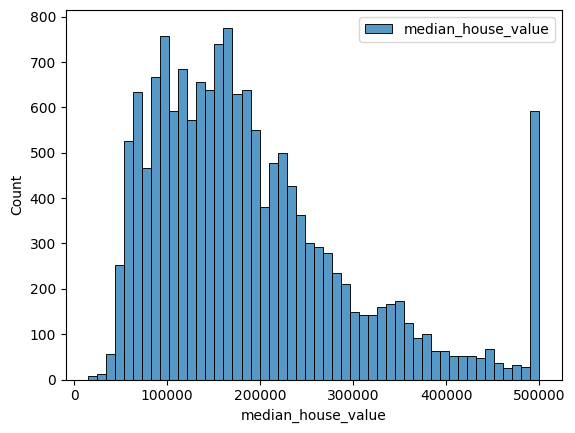

In [33]:
sns.histplot(df.median_house_value, bins=50, label='median_house_value')
plt.legend()

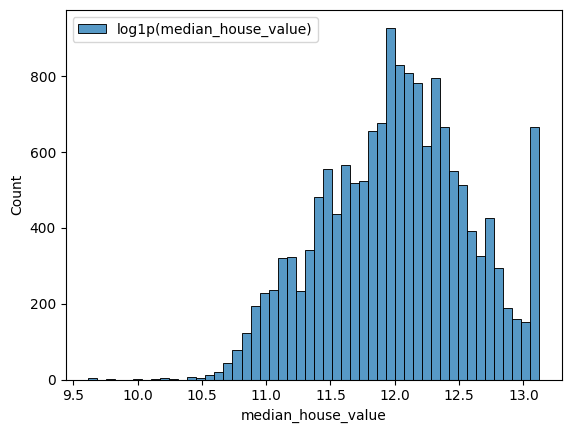

In [34]:
sns.histplot(np.log1p(df.median_house_value), bins=50, label='log1p(median_house_value)')
plt.legend()

In [35]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

target_column = 'median_house_value'

y_train = np.log1p(df_train[target_column].values)
y_val = np.log1p(df_val[target_column].values)
y_test = np.log1p(df_test[target_column].values)

del df_train[target_column]
del df_val[target_column]
del df_test[target_column]

In [36]:
df_train[:1].T

,0
longitude,-120.25
latitude,37.93
housing_median_age,13.0
total_rooms,493.0
total_bedrooms,76.0
population,196.0
households,68.0
median_income,3.375
ocean_proximity,inland


In [37]:
dv = DictVectorizer(sparse=True)

train_dicts = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [39]:
train_dicts[0]

{'longitude': -120.25,
 'latitude': 37.93,
 'housing_median_age': 13.0,
 'total_rooms': 493.0,
 'total_bedrooms': 76.0,
 'population': 196.0,
 'households': 68.0,
 'median_income': 3.375,
 'ocean_proximity': 'inland'}

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity` <=
* `total_rooms`
* `latitude`
* `population`

In [42]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [43]:
list(dv.get_feature_names_out())

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1h_ocean',
 'ocean_proximity=inland',
 'population',
 'total_bedrooms',
 'total_rooms']

In [44]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1h_ocean <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1h_ocean >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* <mark>0.245</mark>
* 0.545
* 0.845

In [45]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [51]:
def rmse(y, y_pred):
  se = (y - y_pred) ** 2
  mse = se.mean()
  return np.sqrt(mse)

def sklearn_rmse(y, y_pred):
    return mean_squared_error(y, y_pred, squared=False)


In [61]:
y_pred = rf.predict(X_val)
print('rmse: %.10f' % rmse(y_val, y_pred))
print('rmse (sklearn): %.10f' % sklearn_rmse(y_val, y_pred))

rmse: 0.2451877248
rmse (sklearn): 0.2451877248


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- <mark>160</mark>

In [67]:
scores =[]

for n in tqdm(range(10, 201, 10)):
  rf = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=1)
  rf.fit(X_train, y_train)

  y_pred = rf.predict(X_val)  
  score = round(rmse(y_val, y_pred), 3)

  scores.append((n, score))

columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.56s/it]


,n_estimators,rmse
0,10,0.245
1,20,0.239
2,30,0.237
3,40,0.235
4,50,0.235
5,60,0.234
6,70,0.234
7,80,0.234
8,90,0.234
9,100,0.234


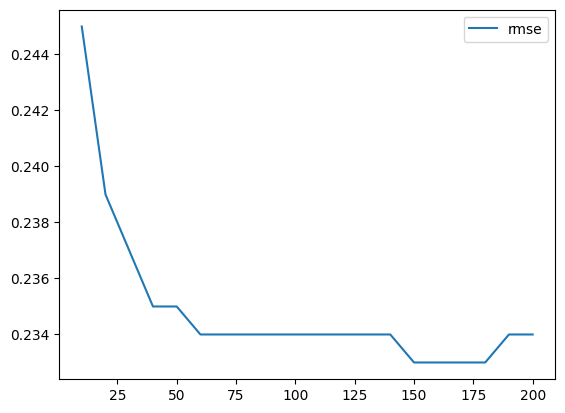

In [69]:
plt.plot(df_scores.n_estimators, df_scores.rmse, label='rmse')
plt.legend()

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* <mark>25</mark>

In [71]:
scores = []
for d in tqdm([10, 15, 20, 25]):
  for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, max_depth=d, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = round(rmse(y_val, y_pred), 3)
      
    scores.append((d, n, score))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:29<00:00, 37.35s/it]


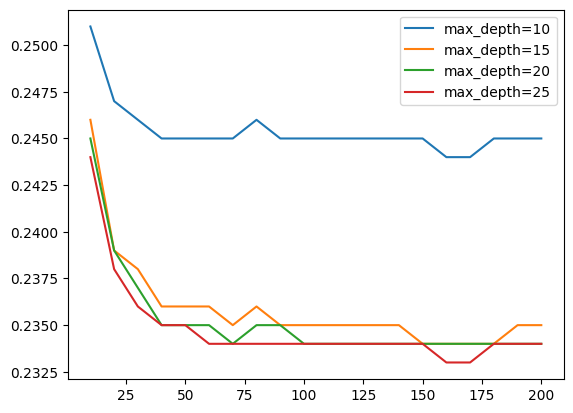

In [72]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)

plt.legend()

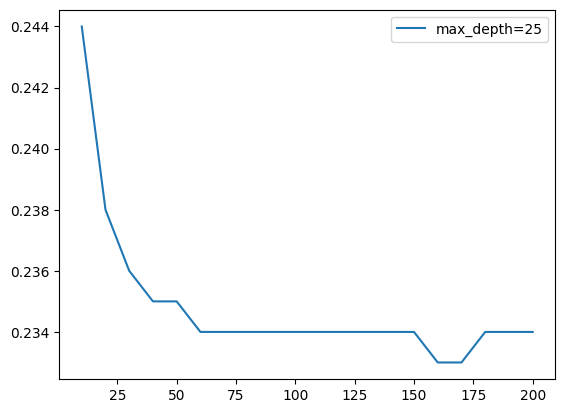

In [73]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

for d in [25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)

plt.legend()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income` <=
* `total_bedrooms`
* `longitude`

In [74]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [75]:
rf.feature_importances_

array([0.01502087, 0.03030503, 0.10195626, 0.08627638, 0.3355917 ,
       0.29247297, 0.07380644, 0.02715851, 0.01589402, 0.02151783])

<BarContainer object of 10 artists>

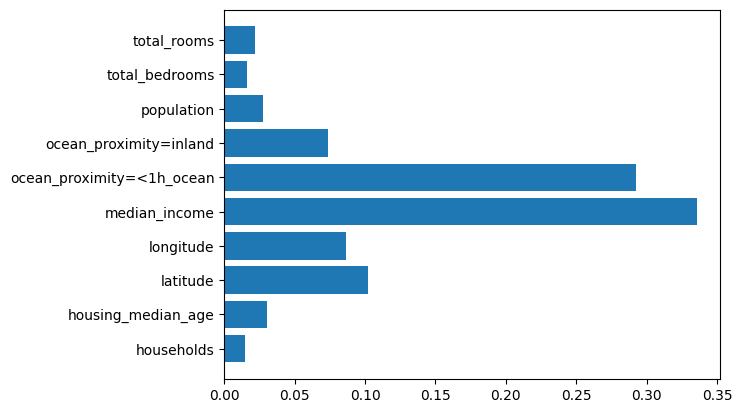

In [76]:
plt.barh(list(dv.get_feature_names_out()), rf.feature_importances_)

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* <mark>0.3</mark>
* 0.1
* Both give equal value

In [87]:
list(dv.get_feature_names_out())

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1h_ocean',
 'ocean_proximity=inland',
 'population',
 'total_bedrooms',
 'total_rooms']

In [91]:
features = list(dv.get_feature_names_out())
features= [i.replace("=<", "_").replace("=","_") for i in features]
print(features)

['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximity_1h_ocean', 'ocean_proximity_inland', 'population', 'total_bedrooms', 'total_rooms']


In [92]:
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names=features)

In [93]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [94]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

[0]	train-rmse:0.44350	val-rmse:0.44250
[1]	train-rmse:0.36599	val-rmse:0.36916
[2]	train-rmse:0.31556	val-rmse:0.32382
[3]	train-rmse:0.28541	val-rmse:0.29965
[4]	train-rmse:0.26573	val-rmse:0.28417
[5]	train-rmse:0.25338	val-rmse:0.27463
[6]	train-rmse:0.24157	val-rmse:0.26770
[7]	train-rmse:0.23486	val-rmse:0.26423
[8]	train-rmse:0.22668	val-rmse:0.25820
[9]	train-rmse:0.21995	val-rmse:0.25444
[10]	train-rmse:0.21444	val-rmse:0.25179
[11]	train-rmse:0.21155	val-rmse:0.25054
[12]	train-rmse:0.20729	val-rmse:0.24791
[13]	train-rmse:0.20317	val-rmse:0.24628
[14]	train-rmse:0.20135	val-rmse:0.24630
[15]	train-rmse:0.19858	val-rmse:0.24522
[16]	train-rmse:0.19580	val-rmse:0.24445
[17]	train-rmse:0.19333	val-rmse:0.24395
[18]	train-rmse:0.19107	val-rmse:0.24284
[19]	train-rmse:0.18735	val-rmse:0.24127
[20]	train-rmse:0.18524	val-rmse:0.23978
[21]	train-rmse:0.18332	val-rmse:0.23963
[22]	train-rmse:0.18189	val-rmse:0.23892
[23]	train-rmse:0.18006	val-rmse:0.23847
[24]	train-rmse:0.17869	va

In [95]:
y_pred = model.predict(dval)
score = round(rmse(y_val, y_pred), 3)
score

0.229

In [96]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

[0]	train-rmse:0.52449	val-rmse:0.52045
[1]	train-rmse:0.48736	val-rmse:0.48443
[2]	train-rmse:0.45433	val-rmse:0.45293
[3]	train-rmse:0.42533	val-rmse:0.42550
[4]	train-rmse:0.39987	val-rmse:0.40144
[5]	train-rmse:0.37822	val-rmse:0.38151
[6]	train-rmse:0.35887	val-rmse:0.36393
[7]	train-rmse:0.34177	val-rmse:0.34838
[8]	train-rmse:0.32701	val-rmse:0.33492
[9]	train-rmse:0.31411	val-rmse:0.32333
[10]	train-rmse:0.30326	val-rmse:0.31427
[11]	train-rmse:0.29355	val-rmse:0.30615
[12]	train-rmse:0.28519	val-rmse:0.29922
[13]	train-rmse:0.27760	val-rmse:0.29269
[14]	train-rmse:0.27116	val-rmse:0.28796
[15]	train-rmse:0.26538	val-rmse:0.28380
[16]	train-rmse:0.26012	val-rmse:0.27970
[17]	train-rmse:0.25583	val-rmse:0.27661
[18]	train-rmse:0.25203	val-rmse:0.27388
[19]	train-rmse:0.24818	val-rmse:0.27123
[20]	train-rmse:0.24512	val-rmse:0.26882
[21]	train-rmse:0.24149	val-rmse:0.26669
[22]	train-rmse:0.23895	val-rmse:0.26478
[23]	train-rmse:0.23594	val-rmse:0.26331
[24]	train-rmse:0.23305	va

In [97]:
y_pred = model.predict(dval)
score = round(rmse(y_val, y_pred), 3)
score

0.232